## ResNet (PyTorch Implementation)
https://arxiv.org/abs/1512.03385

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

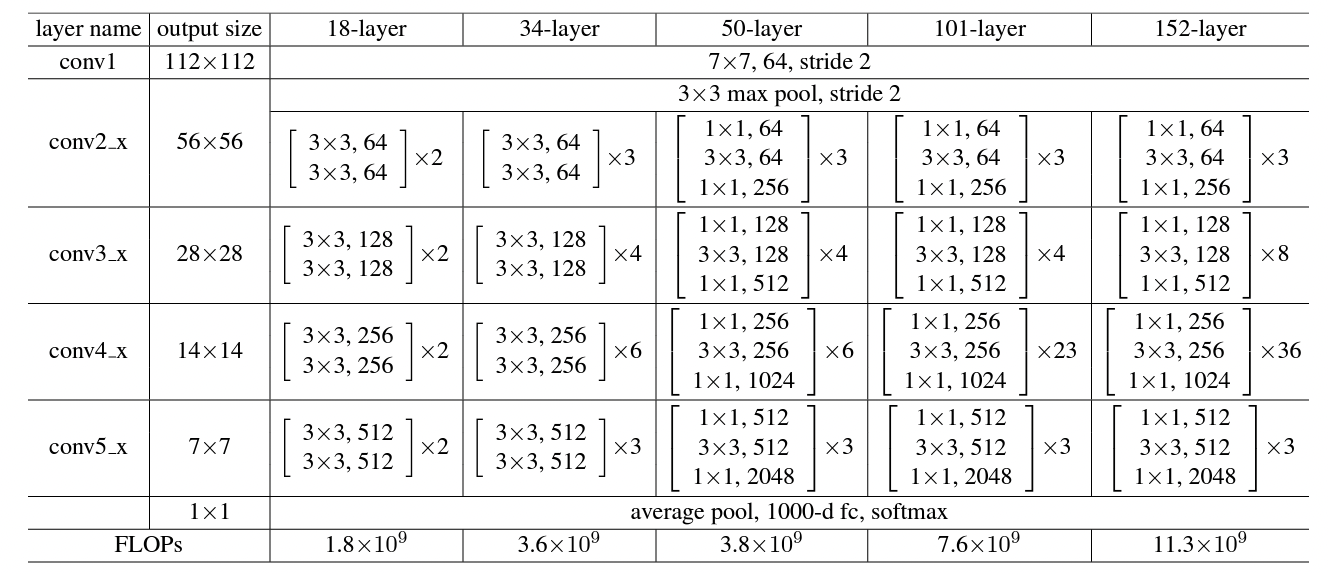

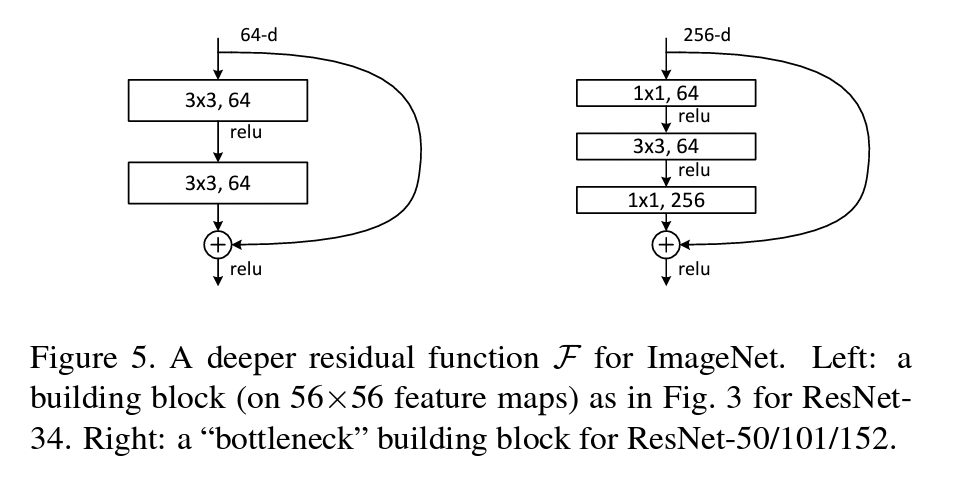

# Resnet 18

## Residual Block

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super(ResidualBlock, self).__init__()
        
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(num_features=out_channels)
            )
            self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                               kernel_size=(3, 3), stride=2, padding=1)
            self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        else:
            self.downsample = nn.Sequential()
            self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                               kernel_size=(3, 3), stride=(1, 1), padding=1)
            self.bn1 = nn.BatchNorm2d(num_features=out_channels)
            
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                               kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)
    
    def forward(self, x):
        identity = self.downsample(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x += identity
        return x

### Testing Residual Block

In [3]:
model = ResidualBlock(in_channels=3, out_channels=64, downsample=True)
X = torch.randn(size=(5, 3, 224, 224))
y = model.forward(X)

In [4]:
model = ResidualBlock(in_channels=64, out_channels=64, downsample=False)
X = torch.randn(size=(5, 64, 224, 224))
y = model.forward(X)

## Building ResNet

In [7]:
class ResNet18(nn.Module):
    def __init__(self, in_channels, out_classes, num_layers):
        super(ResNet18, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(7, 7), stride=2, padding=3), 
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)
        )
        self.layer2 = self.build_residual_layers(num_times=num_layers[0], in_channels=64, out_channels=64)
        self.layer3 = self.build_residual_layers(num_times=num_layers[1], in_channels=64, out_channels=128)
        self.layer4 = self.build_residual_layers(num_times=num_layers[2], in_channels=128, out_channels=256)
        self.layer5 = self.build_residual_layers(num_times=num_layers[3], in_channels=256, out_channels=512)
        self.layer6 = nn.AdaptiveAvgPool2d(1)
        self.layer7 = nn.Linear(in_features=512, out_features=out_classes)
        
    def build_residual_layers(self, num_times, in_channels, out_channels):
        layers = []
        for i in range(num_times):
            if in_channels != out_channels:
                layer = ResidualBlock(in_channels=in_channels, out_channels=out_channels, downsample=True)
                layers.append(layer)
                in_channels = out_channels
            else:
                layer = ResidualBlock(in_channels=in_channels, out_channels=out_channels, downsample=False)
                layers.append(layer)
        return nn.Sequential(*layers)
    
    def forward(self, x):
        print(f'x at input: {x.shape}')
        x = self.layer1(x)
        print(f'x after layer1: {x.shape}')
        x = self.layer2(x)
        print(f'x after layer2: {x.shape}')
        x = self.layer3(x)
        print(f'x after layer3: {x.shape}')
        x = self.layer4(x)
        print(f'x after layer4: {x.shape}')
        x = self.layer5(x)
        print(f'x after layer5: {x.shape}')
        x = F.relu(self.layer6(x))
        print(f'x after layer6: {x.shape}')
        x = torch.flatten(x, start_dim=1, end_dim=3)
#         x = x.view(-1, 512)
        print(f'x flatten: {x.shape}')
        return self.layer7(x)

In [8]:
model = ResNet18(in_channels=3, out_classes=1000, num_layers=[2, 2, 2, 2])
X = torch.randn(size=(5, 3, 224, 224))
y = model.forward(X)

x at input: torch.Size([5, 3, 224, 224])
x after layer1: torch.Size([5, 64, 56, 56])
x after layer2: torch.Size([5, 64, 56, 56])
x after layer3: torch.Size([5, 128, 28, 28])
x after layer4: torch.Size([5, 256, 14, 14])
x after layer5: torch.Size([5, 512, 7, 7])
x after layer6: torch.Size([5, 512, 1, 1])
x flatten: torch.Size([5, 512])
